**2021/22**

# Binary classification
This lecture is about binary classification of discrete data.

Previously we have setup a ML pipeline to work with a linear regression algorithm. Now the focus is on binary classification in a discrete space. 

The dataset under consideration is from the domain of financial markets. As expected, we will be using Apache Spark MLlib.

# ML pipelines

In a prior notebook we have used pipelines to specify stages upon which data is submitted to for processing. But at the time we barely got into details. 

As stated in the Spark's programming guide, **"ML Pipelines provide a uniform set of high-level APIs built on top of DataFrames that help users create and tune practical machine learning pipelines."**

Hence, it is possible to combine multiple algorithms into a single pipeline, or workflow. Besides DataFrames, it involves the following:
1. Transformer: an algorithm which can transform one DataFrame into another DataFrame. For example, an ML model is a Transformer which transforms a DataFrame with features into a DataFrame with predictions.
2. Estimator: an algorithm which can be fit on a DataFrame to produce a Transformer. For example, a learning algorithm is an Estimator which trains on a DataFrame and produces a model.
3. Pipeline: the way to chain multiple Transformers and Estimators together to specify an ML workflow. 4. Parameter: all Transformers and Estimators share a common API for specifying parameters.
Further details can be found in http://spark.apache.org/docs/latest/ml-pipeline.html



Recall that, in general, a typical ML workflow is designed to work as depicted below:

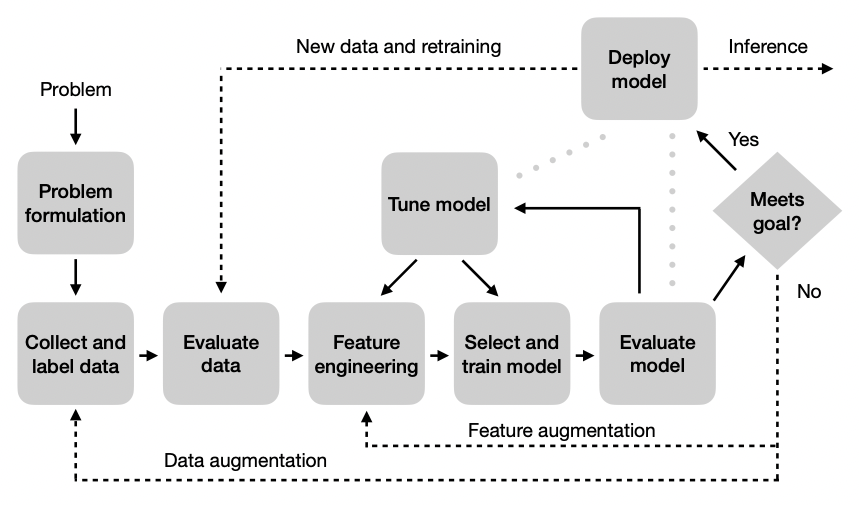

# Problem formulation

This exercise is about stock market prediction in the financial industry. Our case-study and dataset is based on a past Kaggle competition, which details can be found in https://www.kaggle.com/c/jane-street-market-prediction .

Obviously we are not going to create a complex quantitative trading system but just work on a tiny bit - to deciding whether a particular trade proposal is going to be accepted, so traded, or not. In the end, it is a binary classification problem.

Basically, the functional requirements for the Spark program we are about to create are as follows:
1. To load the dataset under analysis and making sure it can be further processed by a ML classifier.
2. To create a classification model supported by a SVM algorithm that is fit for the purpose.
3. For each day, to compute the daily score as the sum of the product **weight x resp** (see schema below)
of the trades the system opt to trade in that day. In that respect, the data to be processed is different from the one being used to create the model.

You can find the file dataset JaneStreetMarket.csv.zip in:


https://iscteiul365.sharepoint.com/:u:/s/G365_UC_AlgoritmosparaBigData/Ebj3nk6DLhZHpuoZFEeptqcB6wovOyeUgi72o7QLC-kBeQ?e=GHSn4C


**Context**

Financial markets are very complex. In such a fast-moving environment, electronic trading allows for thousands of transactions to occur within a fraction of a second, and so providing many opportunities to find and take advantage of price differences in real-time.
In an efficient market, buyers and sellers would have all the information they need to make rational decisions. As result, products remain at fair values, not undervalued nor overpriced. But in the real world, markets do not work like that.

Developing trading strategies to identify and take advantage of inefficiencies is challenging. Even if a strategy is profitable at some point in time, it may not be in the future, and market volatility makes it impossible to predict the profitability of any given trade with certainty. It is hard to distinguish good luck from good trading decision.

Hence, the goal is to build a quantitative trading model to maximize returns using real time market data. Once the model faces trading opportunities electronically, it must decide whether to accept or reject them.
The all building process includes testing its predictiveness against future market returns, as well as checking against historical data, the so-called backtesting. There are a few more notes worth considering, namely:

- The development of good models is very challenging. For example, (i) we may collect too much noise from the market data, (ii) there will be redundancy in the information collected, (iiI) we may experience strong feature correlations, (iv) it is difficult to establish a proper mathematical formulation, etc.
- An highly predictive model, which selects the right trades to execute, will contribute to pushing prices closer to fair values, as it sends correct messages to the market.
- As more people are using this kind of strategies, the slimest advantage due to having good models will pay off.


**Market data**


The dataset we are going to use relates to the Kaggle competition mentioned above. It contains an anonymized set of features, feature_{0...129}, representing real stock market data features. For example, trading volume and volatility in various time horizons, statistical indicators like *Relative Strength Index (RSI)*, etc.

Each row in the dataset represents a trading opportunity, for which the system will be predicting an action value: 1 to make the trade or 0 to pass on it.
For each trade, there is an associated `weight` and `resp`: 
- The `weight` is the importance of the trade like for example a ratio of transaction cost or, in other words, the capital invested in the trade.
- The `resp` represents the return of the trade, and we can have additional returns over specific but not revealed time horizons. But what matters the most is `resp`.

The data also includes the day of the trade (as a number) and a value *ts_id* representing time ordering.


The **data schema** of the dataset is the following:

|Column     | Type| Description |
|:---:|:---:| :---:| 
| **date** |Integer| Day of the trade|
| **weight** | Double | The importante of the trade. When 0, it does not contribute for the score of the evaluation of the model, but it is included for the purpose of completeness |
| **resp_1** | Double | Value related to returns over time horizon 1 |
| **resp_2** | Double | Value related to returns over time horizon 2 |
| **resp_3**  | Double | Value related to returns over time horizon 3 |
| **resp_4** | Double | Value related to returns over time horizon 4 |
| **resp** | Double | Value e.g. returns |
| **feature_0** | Double  | Value of anonymized feature 0 |
| ... |  ... | Columns with features 1 to 128 |
| **feature_129** | Double |  Value of anonymized feature 129 |
| **ts_id** | Integer |  Time ordering |



In [ ]:
# If we need to install some packages, e.g. matplotlib

# ! pip3 install matplotlib
# ! pip3 install seaborn

In [1]:
# Some imports 

import os 

import numpy as np 
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Useful visualization functions

Some functions that we can use to plot data but as Python dataframes.

**Disclaimer**: these functions are broadly distributed among users. Further adjustments are needed and/or advisable. Feel free to use your own plotting functions.

In [2]:
def plotHistogram(df, xcol, huecol):
    sns.histplot(data=df, x=xcol, hue=huecol, multiple="stack")

In [3]:
def plot(df, xcol, ycol):
    sns.lineplot(data=df, x=xcol, y=ycol)

In [4]:
def plotScatter(df, xcol, ycol, huecol):
    sns.scatterplot(data=df, x=xcol, y=ycol, hue=huecol)

In [5]:
def plotScatterMatrix(df, huecol):
    sns.pairplot(data=df, hue=huecol)

In [6]:
def plotCorrelationMatrix1(df):
    # compute the correlation matrix
    corr = df.corr()

    # generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [7]:
def plotCorrelationMatrix2(df):
    # compute a correlation matrix and convert to long-form
    corr_mat = df.corr().stack().reset_index(name="correlation")
    # draw each cell as a scatter point with varying size and color
    g = sns.relplot(
        data=corr_mat,
        x="level_0", y="level_1", hue="correlation", size="correlation",
        palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
        height=10, sizes=(50, 250), size_norm=(-.2, .8),
    )

    # tweak the figure to finalize
    g.set(xlabel="", ylabel="", aspect="equal")
    g.despine(left=True, bottom=True)
    g.ax.margins(.02)
    for label in g.ax.get_xticklabels():
        label.set_rotation(90)
    for artist in g.legend.legendHandles:
        artist.set_edgecolor(".7")

# Collect and label data

## Data ingestion

In [8]:
! pwd 
! ls -la

/home/big/praticas/Aula_05
total 6173600
drwxrwxr-x 4 big big       4096 Mar 24 11:13 .
drwxrwxr-x 7 big big       4096 Mar 24 09:45 ..
-rw-rw-r-- 1 big big     385239 Mar 24 11:13 Classification.ipynb
drwxrwxr-x 2 big big       4096 Mar 24 09:46 .ipynb_checkpoints
-rwxrw-rw- 1 big big 6321353567 Dec 18  2020 JaneStreetMarket.csv
drwxrwxr-x 4 big big       4096 Mar 24 09:43 .svn


In [9]:
! head -n 2 JaneStreetMarket.csv
! tail -n 2 JaneStreetMarket.csv

date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_83,feature_84,feature_85,feature_86,feature_

In [10]:
# some Spark related imports we will use hereafter

import sys

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation, ChiSquareTest
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [11]:
# Build a SparkSession instance if one does not exist. Notice that we can only have one per JVM

spark = SparkSession\
    .builder\
    .appName("JaneStreetMarket")\
    .config("spark.sql.shuffle.partitions",6)\
    .getOrCreate()

In [12]:
# Read the dataset 

df_raw = spark.read.csv("JaneStreetMarket.csv", header="true", inferSchema="true", sep=',')

## Columns to keep

In [14]:
# check the data - schema, show and and count

df_raw.printSchema()
df_raw.show(2, vertical=True)
df_raw.count()

root
 |-- date: integer (nullable = true)
 |-- weight: double (nullable = true)
 |-- resp_1: double (nullable = true)
 |-- resp_2: double (nullable = true)
 |-- resp_3: double (nullable = true)
 |-- resp_4: double (nullable = true)
 |-- resp: double (nullable = true)
 |-- feature_0: integer (nullable = true)
 |-- feature_1: double (nullable = true)
 |-- feature_2: double (nullable = true)
 |-- feature_3: double (nullable = true)
 |-- feature_4: double (nullable = true)
 |-- feature_5: double (nullable = true)
 |-- feature_6: double (nullable = true)
 |-- feature_7: double (nullable = true)
 |-- feature_8: double (nullable = true)
 |-- feature_9: double (nullable = true)
 |-- feature_10: double (nullable = true)
 |-- feature_11: double (nullable = true)
 |-- feature_12: double (nullable = true)
 |-- feature_13: double (nullable = true)
 |-- feature_14: double (nullable = true)
 |-- feature_15: double (nullable = true)
 |-- feature_16: double (nullable = true)
 |-- feature_17: double (nu

22/03/24 10:09:12 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


-RECORD 0---------------------------
 date        | 0                    
 weight      | 0.0                  
 resp_1      | 0.00991599128470742  
 resp_2      | 0.014078579320036337 
 resp_3      | 0.008773048452656298 
 resp_4      | 0.001390366729680... 
 resp        | 0.006270362237518486 
 feature_0   | 1                    
 feature_1   | -1.8727463368135608  
 feature_2   | -2.1912424029615183  
 feature_3   | -0.4741627286969693  
 feature_4   | -0.3230458329243565  
 feature_5   | 0.014688290158842756 
 feature_6   | -0.00248357958237... 
 feature_7   | 0.051776552018935905 
 feature_8   | 0.026828095990954034 
 feature_9   | -0.9899824158411226  
 feature_10  | -1.055090324805692   
 feature_11  | 0.08912156181299187  
 feature_12  | 0.04948553515401576  
 feature_13  | -2.6676705903730658  
 feature_14  | -2.001474548611508   
 feature_15  | -1.7035946193767628  
 feature_16  | -2.1968922079757065  
 feature_17  | 0.12121931699105569  
 feature_18  | 0.11358210894993148  
 

2390491

It seems there are no reasons to drop any column.

# Evaluate data

Let us get some data insight, with some exploratory data analysis based on descriptive statistics and visualizations.

In [13]:
# Check some column statistics, one by one.
# Leave aside those that are named like "feature_nn"

for cl in df_raw.columns:
    if not 'feature' in cl:
        df_raw.describe(cl).show()


+-------+------------------+
|summary|              date|
+-------+------------------+
|  count|           2390491|
|   mean|247.86684241856588|
| stddev|152.27462981867356|
|    min|                 0|
|    max|               499|
+-------+------------------+



+-------+------------------+
|summary|            weight|
+-------+------------------+
|  count|           2390491|
|   mean|3.0315352105292996|
| stddev| 7.672793674716166|
|    min|               0.0|
|    max| 167.2937151011765|
+-------+------------------+



+-------+--------------------+
|summary|              resp_1|
+-------+--------------------+
|  count|             2390491|
|   mean|1.434968962417134E-4|
| stddev|0.008930162685640897|
|    min| -0.3675042697357761|
|    max| 0.24534767084967626|
+-------+--------------------+



+-------+--------------------+
|summary|              resp_2|
+-------+--------------------+
|  count|             2390491|
|   mean|1.980748897542225E-4|
| stddev|0.012302356799785209|
|    min| -0.5328333596070493|
|    max| 0.29493394715254195|
+-------+--------------------+



+-------+--------------------+
|summary|              resp_3|
+-------+--------------------+
|  count|             2390491|
|   mean| 2.82418275996942E-4|
| stddev|0.019068820653076995|
|    min| -0.5681196243069963|
|    max|  0.3265596519689709|
+-------+--------------------+



+-------+--------------------+
|summary|              resp_4|
+-------+--------------------+
|  count|             2390491|
|   mean|4.350200749101190...|
| stddev| 0.03291224421808384|
|    min| -0.5987447058964646|
|    max|  0.5113794579729931|
+-------+--------------------+



+-------+-------------------+
|summary|               resp|
+-------+-------------------+
|  count|            2390491|
|   mean|4.08311288054244E-4|
| stddev|0.02693608603654809|
|    min|-0.5493844963458359|
|    max| 0.4484615812436584|
+-------+-------------------+



+-------+-----------------+
|summary|            ts_id|
+-------+-----------------+
|  count|          2390491|
|   mean|        1195245.0|
| stddev|690075.4555102411|
|    min|                0|
|    max|          2390490|
+-------+-----------------+



Following previous understanding, all collected data should be considered as of interest.

# Feature Engineering

Now we have to prepare data in a way that it can be properly used by ML algorithms, which includes selection and extraction of features, as well as dealing with poor data quality if that is the case.

As we can see, all columns are numeric. Furthermore, data types are OK.

## Data cleasing

We will look at
* Nulls
* Extreme values e.g. outliers

In [14]:
# Nulls: if needed, the brute-force solution: remove rows where at least one of the columns is null or NaN value

# checking the sizes, just to make sure we can move on

[df_raw.count(), df_raw.dropna().count()]

22/03/26 08:24:17 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


[2390491, 2390491]

In [ ]:
# Outliers: for that, we use summary(), one column by one, except those starting with feature_ as above

for cl in df_raw.columns:
    if not 'feature' in cl:
        df_raw.select(cl).summary().show()

No nulls. Fine. And in respect to outliers, likewise there are no problems.

## Saving clean data

In [15]:
# As we have a large dataset, we should also have a smaller one,
# just for the purpose of working locally, maybe starting 
# from the begining (as it is sorted by timing)

small_num_rows = df_raw.select("date").filter("date <= 50").count()
small_num_rows = 300000 # out of 2 390 491 
df_small = df_raw.limit(small_num_rows)
small_num_rows

300000

In [16]:
# Save the smaller version to a file for future use in case of need

df_small.write.mode("overwrite").parquet("small-clean-janestreetmarket")

# and later on, we can use spark.read.parquet() to load files

In [17]:
# Also, although no changes were made to the initial dataset, 
# it may be convenient to have the original data stored in 
# the parquet format as well. It will be the normal dataset

df_raw.write.mode("overwrite").parquet("small-clean-janestreetmarket")

In [18]:
# Check in the running directory if that was accomplished

! ls -la

total 6173616
drwxrwxr-x 5 big big       4096 Mar 26 09:50 .
drwxrwxr-x 7 big big       4096 Mar 24 09:45 ..
-rw-rw-r-- 1 big big     386598 Mar 26 09:50 Classification.ipynb
drwxrwxr-x 2 big big       4096 Mar 24 09:46 .ipynb_checkpoints
-rwxrw-rw- 1 big big 6321353567 Dec 18  2020 JaneStreetMarket.csv
drwxr-xr-x 2 big big      16384 Mar 26 09:48 small-clean-janestreetmarket
drwxrwxr-x 4 big big       4096 Mar 24 09:43 .svn


In [19]:
! ls -la small-clean-janestreetmarket

total 2345760
drwxr-xr-x 2 big big    16384 Mar 26 09:48 .
drwxrwxr-x 5 big big     4096 Mar 26 09:50 ..
-rw-r--r-- 1 big big 50488183 Mar 26 09:17 part-00000-ed5bde53-a5bf-4b9b-a5fc-0d0dfb0b360c-c000.snappy.parquet
-rw-r--r-- 1 big big   394448 Mar 26 09:17 .part-00000-ed5bde53-a5bf-4b9b-a5fc-0d0dfb0b360c-c000.snappy.parquet.crc
-rw-r--r-- 1 big big 50476918 Mar 26 09:17 part-00001-ed5bde53-a5bf-4b9b-a5fc-0d0dfb0b360c-c000.snappy.parquet
-rw-r--r-- 1 big big   394360 Mar 26 09:17 .part-00001-ed5bde53-a5bf-4b9b-a5fc-0d0dfb0b360c-c000.snappy.parquet.crc
-rw-r--r-- 1 big big 50591821 Mar 26 09:18 part-00002-ed5bde53-a5bf-4b9b-a5fc-0d0dfb0b360c-c000.snappy.parquet
-rw-r--r-- 1 big big   395260 Mar 26 09:18 .part-00002-ed5bde53-a5bf-4b9b-a5fc-0d0dfb0b360c-c000.snappy.parquet.crc
-rw-r--r-- 1 big big 50273557 Mar 26 09:18 part-00003-ed5bde53-a5bf-4b9b-a5fc-0d0dfb0b360c-c000.snappy.parquet
-rw-r--r-- 1 big big   392772 Mar 26 09:18 .part-00003-ed5bde53-a5bf-4b9b-a5fc-0d0dfb0b360c-c000.snappy

In [20]:
! ls -la clean-janestreetmarket

ls: cannot access 'clean-janestreetmarket': No such file or directory


## Data to be used hereafter

In [21]:
# df_clean = 
df_clean = df_small

In [22]:
# Delete memory consuming variables that are no longer needed

del df_raw, df_small

## Final  overview
After establishing the clean data to be used, let us get an overview about what we have achieved, with some statistics and visualizations.

In [23]:
# Particular columns to check

cls1 = ["resp_1", "resp_2", "resp_3", "resp_4", "resp"]
cls2 = ["date", "weight", "ts_id"] 
cls3 = ["date", "weight", "resp_1", "resp_2", "resp_3", "resp_4", "resp", "ts_id" ] 


### Descriptive statistics

In [24]:
# Describe

df_clean.describe(cls1).show()
df_clean.describe(cls2).show()

+-------+--------------------+--------------------+--------------------+--------------------+--------------------+
|summary|              resp_1|              resp_2|              resp_3|              resp_4|                resp|
+-------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  count|              300000|              300000|              300000|              300000|              300000|
|   mean|3.558767517605449...|4.034667925571431E-4|6.987110574429676E-4|0.001249073517940...| 9.87971106536969E-4|
| stddev|0.009819043918059494| 0.01382587952830437|0.021327385307623233| 0.03707982165854835|0.030641444790803753|
|    min| -0.3675042697357761| -0.5328333596070493| -0.5681196243069963| -0.5588167356050172|-0.43402042775308974|
|    max|  0.2420970618388233|  0.2814807713704391|  0.3265596519689709|  0.5113794579729931|  0.4484615812436584|
+-------+--------------------+--------------------+--------------------+--------

+-------+------------------+------------------+-----------------+
|summary|              date|            weight|            ts_id|
+-------+------------------+------------------+-----------------+
|  count|            300000|            300000|           300000|
|   mean|          23.18706| 2.494544273754487|         149999.5|
| stddev|13.523522649145173| 6.725692482207057|86602.68471589088|
|    min|                 0|               0.0|                0|
|    max|                44|163.61175342760416|           299999|
+-------+------------------+------------------+-----------------+



In [ ]:
# Summary

for cl in cls1:
    df_clean.select(cl).summary().show()

for cl in cls2:
    df_clean.select(cl).summary().show()

### Correlations

In [25]:
# check some columns e.g. resp vs weight; 
# Correlation needs vectors so we convert to vector column first

# the columns to compute correlations
#cols_corr = df_clean.columns  # or specific ones
cols_corr = cls2

vector_col = "corr_features"
assembler = VectorAssembler(inputCols=cols_corr, outputCol=vector_col)
df_vector = assembler.transform(df_clean).select(vector_col)

# get correlation matrix - it can be Pearson’s (default) or Spearman’s correlation

# corr = Correlation.corr(df_vector, vector_col).head()
# print("Pearson correlation matrix:\n" + str(corr[0]))

# corr = Correlation.corr(df_vector, vector_col, "spearman").head()
# print("Spearman correlation matrix:\n" + str(corr[0]))

corrmatrix = Correlation.corr(df_vector, vector_col).collect()[0][0].toArray().tolist()
corrmatrix

22/03/26 10:38:56 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/03/26 10:38:56 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


[[1.0, -0.01279708901139789, 0.9988583009782549],
 [-0.01279708901139789, 1.0, -0.01221511687708992],
 [0.9988583009782549, -0.01221511687708992, 1.0]]

In [26]:
# Just for visualization purposes, convert to Pandas 

df_plot = pd.DataFrame(data = corrmatrix, index=cols_corr, columns=cols_corr)

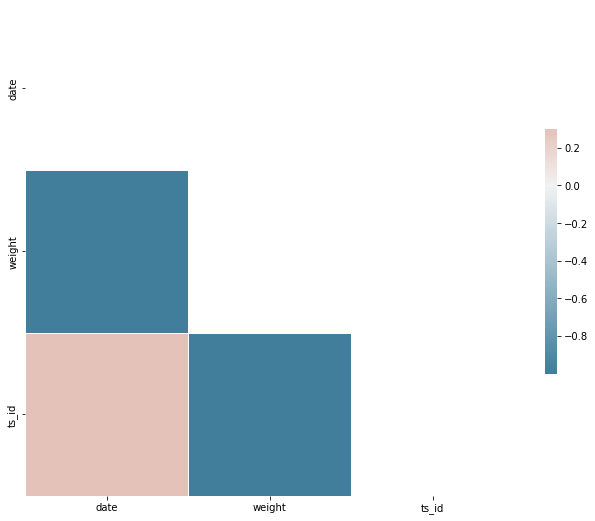

In [27]:
# a plot 
plotCorrelationMatrix1(df_plot)

### Daily averages
To put into context, it also seems sensible to look at daily averages, since in most of the days the intra-day behaviour does not change that much, relatively speaking.

In [28]:
# Trading days, sorted

df_clean.select("date").distinct().sort("date").show()
df_clean.select("date").distinct().count()

+----+
|date|
+----+
|   0|
|   1|
|   2|
|   3|
|   4|
|   5|
|   6|
|   7|
|   8|
|   9|
|  10|
|  11|
|  12|
|  13|
|  14|
|  15|
|  16|
|  17|
|  18|
|  19|
+----+
only showing top 20 rows



45

In [29]:
# Check average values by day 

df_clean_daily = df_clean.groupBy("date").mean() 
df_clean_daily.columns

['date',
 'avg(date)',
 'avg(weight)',
 'avg(resp_1)',
 'avg(resp_2)',
 'avg(resp_3)',
 'avg(resp_4)',
 'avg(resp)',
 'avg(feature_0)',
 'avg(feature_1)',
 'avg(feature_2)',
 'avg(feature_3)',
 'avg(feature_4)',
 'avg(feature_5)',
 'avg(feature_6)',
 'avg(feature_7)',
 'avg(feature_8)',
 'avg(feature_9)',
 'avg(feature_10)',
 'avg(feature_11)',
 'avg(feature_12)',
 'avg(feature_13)',
 'avg(feature_14)',
 'avg(feature_15)',
 'avg(feature_16)',
 'avg(feature_17)',
 'avg(feature_18)',
 'avg(feature_19)',
 'avg(feature_20)',
 'avg(feature_21)',
 'avg(feature_22)',
 'avg(feature_23)',
 'avg(feature_24)',
 'avg(feature_25)',
 'avg(feature_26)',
 'avg(feature_27)',
 'avg(feature_28)',
 'avg(feature_29)',
 'avg(feature_30)',
 'avg(feature_31)',
 'avg(feature_32)',
 'avg(feature_33)',
 'avg(feature_34)',
 'avg(feature_35)',
 'avg(feature_36)',
 'avg(feature_37)',
 'avg(feature_38)',
 'avg(feature_39)',
 'avg(feature_40)',
 'avg(feature_41)',
 'avg(feature_42)',
 'avg(feature_43)',
 'avg(feature

In [30]:
df_clean_daily.count()

45

In [31]:
df_plot = df_clean_daily.toPandas()

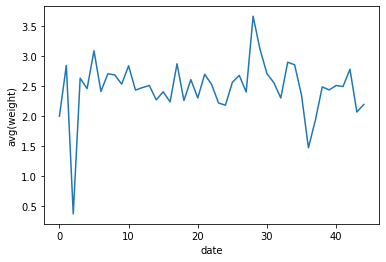

In [32]:
# some plots

plot(df_plot, 'date', 'avg(weight)')

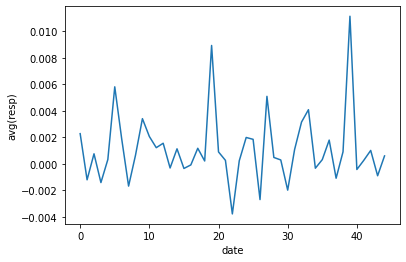

In [33]:
plot(df_plot, 'date', 'avg(resp)')

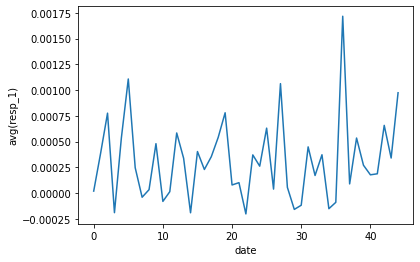

In [34]:

plot(df_plot, 'date', 'avg(resp_1)')

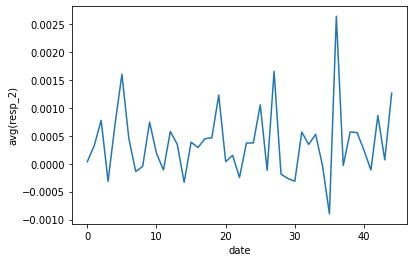

In [35]:
plot(df_plot, 'date', 'avg(resp_2)')

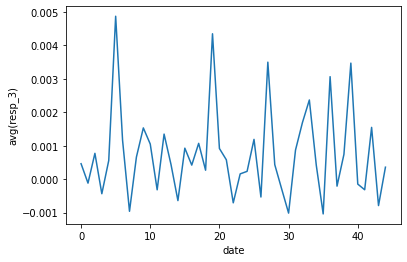

In [36]:

plot(df_plot, 'date', 'avg(resp_3)')


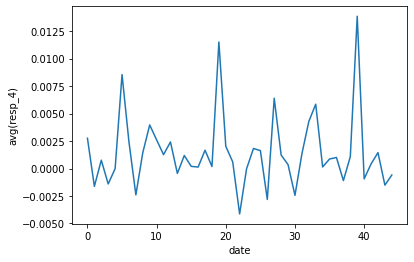

In [37]:
plot(df_plot, 'date', 'avg(resp_4)')

## Columns selection

It is time to start thinking about which columns to use in the model, whether existing or new derived ones. To do so, the best we understand what the business is all about the better, including in relation to the characteristics of the data we were given. Statistics we have made, and more to do, would help to figure out patterns of interest. (Recall that features in this problem are anonymized)

However, in the context of this problem we will make straightforward decisions so leaving aside a thoroughly business analysis for the experts. But at the end of the day, there is a score to pursuit, as pointed out in the problem formulation:

    For each day, to compute the daily score as the sum of the product `weight * resp` (see schema above) of the trades the system opt to trade in that day. The data to be processed shall be different from the one being  used to create the model.

Notice: MLlib provides a set of tools to help tackling this issue of features. See http://spark.apache.org/docs/latest/ml-features.html . 
But we leave it for another exercise.

In [38]:
# All columns are numeric

cols = df_clean.columns

cols_features_nn = [cl for cl in cols if 'feature' in cl]

cols_non_feature_nn = ["date", "weight", "resp_1", "resp_2", "resp_3", "resp_4", "resp", "ts_id" ]
                     
cols_non_features_nn = [cl for cl in cols if cl not in cols_features_nn]

[cols_non_features_nn, len(cols_features_nn)]

[['date', 'weight', 'resp_1', 'resp_2', 'resp_3', 'resp_4', 'resp', 'ts_id'],
 130]

In [40]:
# Columns as features - let us use cols_features_nn

features = cols_features_nn

# Set the label, the target to predict: we should trade when weight * resp is positive 

df_preprocessed = (df_clean.withColumn("label", when(expr("weight > 0") & expr("resp > 0"), 1).otherwise(0)))

df_preprocessed.select("weight", "resp", "label").show(20)

+-------------------+--------------------+-----+
|             weight|                resp|label|
+-------------------+--------------------+-----+
|                0.0|0.006270362237518486|    0|
| 16.673514760471395|-0.00979168234968...|    0|
|                0.0|  0.0239701262920541|    0|
|                0.0|-0.00320009790277...|    0|
|0.13853087008571327|-0.00260357586807...|    0|
|                0.0|0.001281698633697...|    0|
|0.19057532001122954|7.091052930215457E-4|    1|
|  3.820844307682101| 0.03347260943620305|    1|
| 0.1165565792165983|-0.00167740650488...|    0|
|0.16011738233685538|0.020316999907101847|    1|
|0.10965051478911862|-6.90382018446591...|    0|
| 0.1994352140153116|-0.00214413094460...|    0|
| 0.2981084239756894|-0.00270683437730...|    0|
| 0.7593670902453062| -0.0559789020313077|    0|
| 0.8118507688088187|-0.01181833740898...|    0|
| 0.0985388640728885|-0.01304058984490...|    0|
| 0.9087237198494212|0.028325255126163382|    1|
| 1.2113994388538791

# Select and train model

Now it is time to train and test a model to be used for binary classification, that is, to decide whether to trade or not.

We are going to use a Linear Support Vector Machine algorithm, as presented in
http://spark.apache.org/docs/latest/ml-classification-regression.html#linear-support-vector-machine . 

But before going further, probably it is worth having a look at both the supervised learning and the ML pipeline slides from the lectures.

## Train/test split

The step of creating a ML model means we should keep some part of the data in the dark.
Standard split is 80/20 (or 70/30 if dataset is really large). 

Recall that if the test part is relatively too small, then the model will memorize the data so it will reach an overfit situation. That would be bad as it no longer have data to evaluate how well it will generalize to unseen data.


In [41]:
# train/test split

df_train, df_test = df_preprocessed.randomSplit([0.8, 0.2], 42)

# caching data ... but just the training part
df_train.cache()

# print the number of rows in each part
print(f"There are {df_train.count()} rows in the training set and {df_test.count()} in the test set.")

22/03/26 12:18:22 WARN MemoryStore: Not enough space to cache rdd_173_0 in memory! (computed 67.7 MiB so far)
22/03/26 12:18:22 WARN BlockManager: Persisting block rdd_173_0 to disk instead.


There are 239843 rows in the training set and 60157 in the test set.


**Notice** 

As we did with clean data, we may consider storing the data split into files, should we want to use it elsewhere. 

This relates to the need of guaranteeing of unicidade noutro ambiente eexperiemntal 

We leave it as it is now.

## Features transformation to vector

ML algorithms require that all input features are contained within a single vector. Therefore we need a transformation, so we use the `VectorAsAssembler` transformer.

Transformers accept a DataFrame as input and return a new one with one or more columns appended to it, using a `transform()` method following rule-based transformations - they do not learn from the data. Notice that they are lazily evaluated.

In [42]:
# Put all input features into a single vector, by using a transformer

vec_assembler = VectorAssembler(inputCols=features, outputCol="features") 


## Linear SVM model

Once we have a vector assembled with the features in place, then we can use the `Linear SVM` estimator (the algorithm) to learn from the training data and consequently to build the model. 

In [43]:
# Linear SVC algorithm
# default: featuresCol='features', labelCol='label', predictionCol='prediction'

lsvc = LinearSVC(maxIter=10, regParam=0.1)


## ML pipeline configuration

In [44]:
# The pipeline holds two stages set above: 
#  1. vec_assembler (related to features) 
#  2. lsvc (related to ML estimator)

pipeline = Pipeline(stages=[vec_assembler, lsvc])


## Model fitting
Get the model (as transformer) by fitting the pipeline to training data.

In [45]:
pipeline_model = pipeline.fit(df_train)

22/03/26 13:00:02 WARN MemoryStore: Not enough space to cache rdd_209_0 in memory! (computed 177.1 MiB so far)
22/03/26 13:00:02 WARN BlockManager: Persisting block rdd_209_0 to disk instead.
ERROR:root:KeyboardInterrupt while sending command.                 (0 + 1) / 1]
Traceback (most recent call last):
  File "/opt/spark/python/lib/py4j-0.10.9.3-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/opt/spark/python/lib/py4j-0.10.9.3-src.zip/py4j/clientserver.py", line 475, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

# Evaluate model

Let us evaluate the Linear SVM model.

## Testing the model

It is time to apply the model built to test data. Again, we will use the pipeline set above, meaning the stages already specified will be reused. Notice that, since the pipeline model is a transformer, we can easily apply it to test data.

In [ ]:
# Make predictions on test data and show values of columns of interest

df_prediction = pipeline_model.transform(df_test)

# Check its schema

df_prediction.printSchema()

In [ ]:
# Columns of concern

df_prediction.select("weight", "resp", "label", "features", "rawPrediction", "prediction").show()

## Evaluation metrics

How right was the model? Let us figure out using:
1. Evaluators
2. Confusion matrix


In [ ]:
# Compute evaluation metrics on testing data

prediction_label = df_prediction.select("rawPrediction", "label")  

# supports metricName="areaUnderROC" (default) and "areaUnderPR"
# it relates sensitivity (TP rate) and specificity (FP rate)

evaluator = BinaryClassificationEvaluator()

print("areaUnderROC = " + str(evaluator.evaluate(prediction_label)))


Recalling the confusion matrix:

- True Positive: the prediction was positive and it is true. (Great, we trade and score)
- True Negative: the prediction was negative and it is true. (Fine, we do not trade and so avoiding a loss) 
- False Positive: the prediction was positive and it is false. (Terrible, we trade and have a loss)
- False Negative: the prediction was negative and it is false. (Not so good, we do not trade and therefore missing to score)


 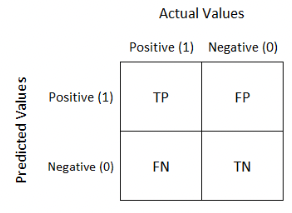

It follows the TP, TN, FP and FN computations.

In [ ]:
# counting rows for each case TP, TN, FP and FN respectively

n = df_prediction.count()
tp = df_prediction.filter(expr("prediction > 0") & expr("label == prediction")).count()
tn = df_prediction.filter(expr("prediction <= 0") & expr("label == prediction")).count()
fp = df_prediction.filter(expr("prediction > 0") & expr("label != prediction")).count()
fn = n - tp - tn - fp
[tp, tn, fp, fn, n]

**Accuracy** = (TP + TN) / (TP + TN + FP + FN)

How often the classifier is correct? (score)

Metric widely used but not so useful when there are many TN cases.

In [ ]:
accuracy = (tp + tn)/(tp + tn + fp + fn)

**Precision** = TP / (TP + FP)

Positive predictive value - proportion of positive results that were correctly identified.

It removes NP and FN from consideration.

In [ ]:
precision = tp/(tp + fp)

**Recall** = TP / (TP + FN)

True positive rate. (hit rate, sensitivity)

In [ ]:
recall = tp/(tp + fn)

**Specifity** = TN / (TN + FP)

True negative rate. (selectivity)

In [ ]:
specifity = tn/(tn + fp)

**F1 score** = 2 * Recall * Precision / (Recall + Precision)

Useful metric because it is difficult to compare two models with low precision and high recall or vice versa. 
Indeed, by combining recall and precision it helps to measure them at once.


In [ ]:
f1_score = 2 * recall * precision / (recall + precision)

In [ ]:
# Confusion matrix conclusions

print("TP = {}, TN = {}, FP = {}, FN = {}, Total = {}".format(tp, tn, fp, fn, n)) 
print("Accuracy = {}".format(accuracy))
print("Precison = {}".format(precision))
print("Recall = {}".format(recall))
print("Specifity = {}".format(specifity))
print("F1 score = {}".format(f1_score))

## Visual analysis
Plotting `label` versus `prediction` obtained above.

In [ ]:
# plots

cols_to_plot = ["date", "label", "prediction"]
df_plot = df_prediction.select(cols_to_plot).limit(100000).toPandas()

In [ ]:
plotScatter(df_plot, "date", "prediction", "label")

## Back to business: the daily score


In [ ]:
# Compute the daily score,
# based on the trades made in that day, as  weight * resp

df_score = df_prediction.withColumn("score", expr("weight * resp * prediction")) 

gdf = df_score.groupBy(df_score.date)
df_daily_score = gdf.agg({"score": "sum"}).sort("date") 

trading_days = df_daily_score.count()
acumulative_score = df_daily_score.agg({"sum(score)": "sum"}).collect()[0][0]

df_daily_score.show()
print("For the {} trading days, the accumulative score is {}".format(trading_days, acumulative_score))

## Saving the pipeline

In [ ]:
# We can save the pipeline for further use should it be required

pipeline.save("pipeline-LinearSVM")

# later on, it can be loaded anywhere


In [ ]:
! ls -la

In [ ]:
! ls -la pipeline-LinearSVM

# Tune model

We should improve the model. For example, we can think about:
- How can we interpret the scores above?
- Could a model with different set of features and/or target engineering would perform better? 
- And what about using real-time data, that is, not training nor testing data?

See the exercise below.

# Additional exercise

Once this exercise has been completed, create a new notebook with similar implementation but using
the following classifiers instead:
1. Logistic Regression 
2. Decision Tree

Also, try to improve the process of feature/target engineering.

See related information in:
http://spark.apache.org/docs/latest/ml-classification-regression.html#logistic-regression (http://spark.apache.org/docs/latest/ml-classification-regression.html#logistic-regression)

http://spark.apache.org/docs/latest/ml-classification-regression.html#decision-tree-classifier (http://spark.apache.org/docs/latest/ml-classification-regression.html#decision-tree-classifier)

# References

* Learning Spark - Lightning-Fast Data Analytics, 2nd Ed. J. Damji, B. Wenig, T. Das, and D. Lee. O'Reilly, 2020
* Spark: The Definitive Guide - Big Data Processing Made Simple, 1st Ed. B. Chambers and M. Zaharia. O'Reilly, 2018
* http://spark.apache.org/docs/latest/ml-guide.html
* https://docs.python.org/3/ 
* https://www.kaggle.com/c/jane-street-market-prediction
